<a href="https://colab.research.google.com/github/Sameersah/decision-trees-ensemble/blob/main/AdaBoost_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# AdaBoost Implementation

AdaBoost updates weights for misclassified samples to focus on harder examples in subsequent iterations.

Steps:
Initialize Weights: Assign equal weights to all samples.
Train Weak Learner: Use a weak learner (e.g., decision stump).
Update Weights: Increase weights for misclassified samples.
Combine Weak Learners: Aggregate predictions using weighted voting.

AdaBoost (Adaptive Boosting) combines multiple weak learners to create a strong classifier. At each iteration:




AdaBoost Accuracy: 89.00%


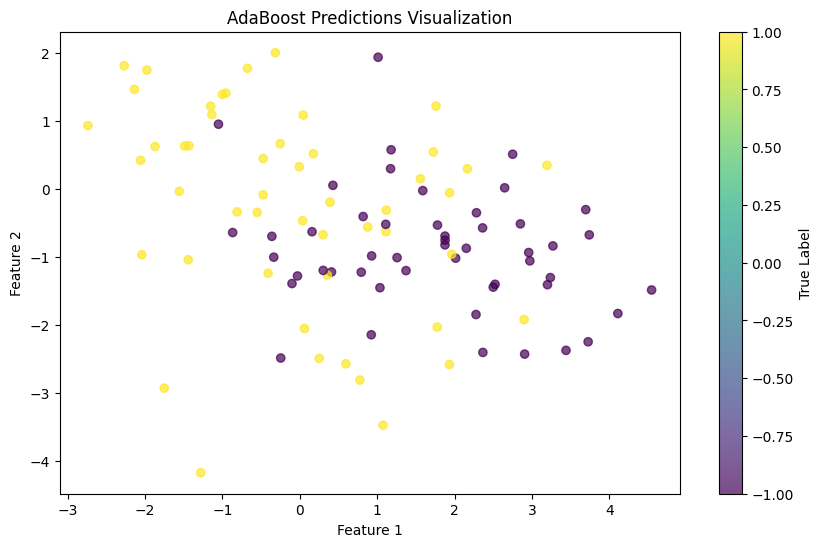

In [1]:
# AdaBoost (Adaptive Boosting) Implementation from Scratch

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class DecisionStump:
    """
    A simple decision stump (one-level decision tree) as the weak learner for AdaBoost
    """
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.polarity = 1
        self.alpha = None

    def fit(self, X, y, sample_weights):
        """
        Find the best decision stump that minimizes weighted error

        Args:
            X (np.array): Feature matrix
            y (np.array): Target labels
            sample_weights (np.array): Sample weights
        """
        num_samples, num_features = X.shape

        # Initialize variables to track the best stump
        min_error = float('inf')

        # Try every feature and every unique value as potential threshold
        for feature_i in range(num_features):
            feature_values = X[:, feature_i]
            unique_thresholds = np.unique(feature_values)

            for threshold in unique_thresholds:
                # Try both polarities (less than or greater than)
                for polarity in [1, -1]:
                    # Predict based on current stump configuration
                    predictions = np.ones(num_samples)
                    if polarity == 1:
                        predictions[feature_values < threshold] = -1
                    else:
                        predictions[feature_values >= threshold] = -1

                    # Calculate weighted error
                    incorrect = predictions != y
                    weighted_error = np.sum(sample_weights[incorrect])

                    # Update best stump if error is lower
                    if weighted_error < min_error:
                        min_error = weighted_error
                        self.feature_index = feature_i
                        self.threshold = threshold
                        self.polarity = polarity

        # Calculate alpha (importance of this weak learner)
        # Use a small epsilon to prevent division by zero
        eps = 1e-10
        self.alpha = 0.5 * np.log((1 - min_error + eps) / (min_error + eps))

        return self

    def predict(self, X):
        """
        Predict labels using the decision stump

        Args:
            X (np.array): Feature matrix

        Returns:
            np.array: Predicted labels
        """
        num_samples = X.shape[0]
        predictions = np.ones(num_samples)

        # Apply threshold condition based on feature and polarity
        if self.polarity == 1:
            predictions[X[:, self.feature_index] < self.threshold] = -1
        else:
            predictions[X[:, self.feature_index] >= self.threshold] = -1

        return predictions

class AdaBoost:
    """
    AdaBoost (Adaptive Boosting) Classifier implementation from scratch
    """
    def __init__(self, n_estimators=50):
        """
        Initialize AdaBoost with number of weak learners

        Args:
            n_estimators (int): Number of weak learners (decision stumps)
        """
        self.n_estimators = n_estimators
        self.estimators = []

    def fit(self, X, y):
        """
        Train AdaBoost classifier

        Args:
            X (np.array): Feature matrix
            y (np.array): Target labels

        Returns:
            self: Trained AdaBoost model
        """
        num_samples, _ = X.shape

        # Initialize sample weights equally
        sample_weights = np.ones(num_samples) / num_samples

        # Initialize cumulative predictions
        self.estimators = []

        # Train weak learners sequentially
        for _ in range(self.n_estimators):
            # Create and fit decision stump
            stump = DecisionStump()
            stump.fit(X, y, sample_weights)

            # Get stump predictions
            stump_preds = stump.predict(X)

            # Calculate weighted error and stump importance
            incorrect = stump_preds != y
            weighted_error = np.sum(sample_weights[incorrect])

            # Update sample weights
            sample_weights *= np.exp(stump.alpha * incorrect)
            sample_weights /= np.sum(sample_weights)  # Normalize

            # Store the stump
            self.estimators.append(stump)

        return self

    def predict(self, X):
        """
        Predict labels for new data

        Args:
            X (np.array): Feature matrix

        Returns:
            np.array: Predicted labels
        """
        # Aggregate predictions from all weak learners
        estimator_preds = np.array([
            stump.alpha * stump.predict(X)
            for stump in self.estimators
        ])

        # Sum predictions and apply sign
        final_predictions = np.sign(np.sum(estimator_preds, axis=0))

        return final_predictions

# Demonstration Function
def demonstrate_adaboost():
    """
    Demonstrate AdaBoost implementation with synthetic data
    """
    # Generate synthetic classification dataset
    X, y = make_classification(
        n_samples=500,
        n_features=10,
        n_informative=5,
        n_redundant=2,
        random_state=42
    )

    # Convert to binary classification (-1 and 1)
    y = np.where(y == 0, -1, 1)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train AdaBoost
    adaboost = AdaBoost(n_estimators=50)
    adaboost.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = adaboost.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"AdaBoost Accuracy: {accuracy * 100:.2f}%")

    return adaboost, X_test, y_test

# Run demonstration
adaboost_model, X_test, y_test = demonstrate_adaboost()

# Optional: Visualization of predictions
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', alpha=0.7)
plt.title("AdaBoost Predictions Visualization")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label='True Label')
plt.show()